<center><h1>McGill University - <b>ECSE 415</b> Introduction to Computer Vision</h1>
<h2><b>Assignment 2 </b>Feature Extraction</h2>
<h4>@author: Alex Wei</h4>
<h4>Last modified: 2023/10/08</h4></center><br>


##***README***
0. Modify the path below to apply globally.
1. (Part 1 - line 17) This is an optimized version with more concise codes, same functionally as the procedure introduced in class using a 3x3 scan window. Referred the some documentation at https://docs.opencv.org/4.8.0/d2/d96/tutorial_py_table_of_contents_imgproc.html.
2. (Part2.1 - step 3) The assignment instruction says "brief". For detailed steps, refer to Lecture 6 sildes.
3. (Part 2.2) Since the objects in A1 images were pretty much black and white, I used different images here for a more challenging and dynamic demostration.
4. (Part 2.3) In this section, it has been observed that scaling up the input image by a factor of 3 or 5 would cause the descriptor-finding process to complain. Therefore, we have to scale down the input image before proceeding.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/ECSE 415/A2/"

Mounted at /content/drive


\
##***1 Harris Corner Detection***

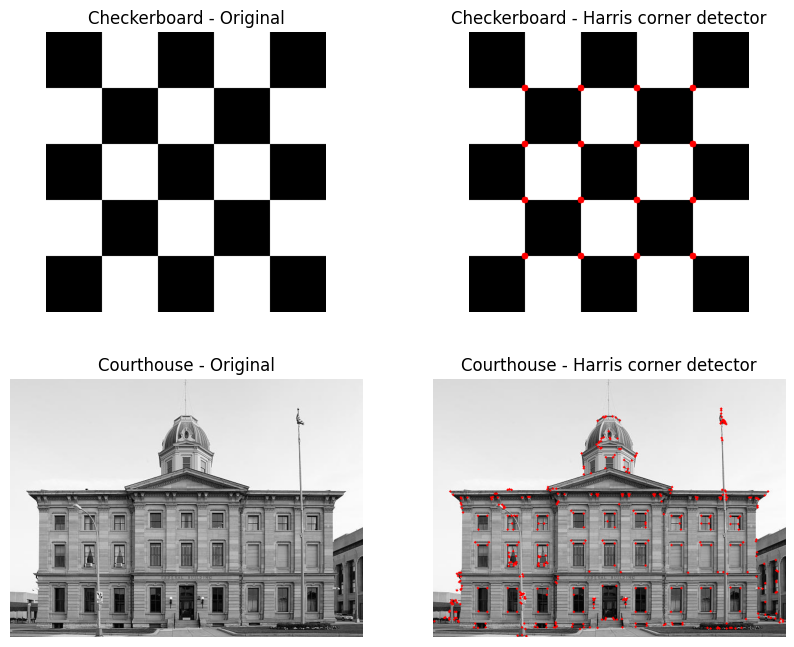

In [ ]:
# implemented following class notes (lec 5, tut 2 & 3)
def harris(image, k = 0.05, threshold = 0.02):
    # 1. Compute the image derivatives (optionally, blur first)
    image = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (5, 5), 1)

    # 2. Compute the square of the derivatives
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 3)
    Ix2, Iy2 = np.square(Ix), np.square(Iy)
    Ixy =Ix * Iy

    # 3. Apply Gaussian Filtering on the output of Step 2
    Ix2_blur = cv2.GaussianBlur(Ix2, (3, 3), 0)
    Iy2_blur = cv2.GaussianBlur(Iy2, (3, 3), 0)
    Ixy_blur = cv2.GaussianBlur(Ixy, (3, 3), 0)

    # 4. Compute the cornerness function response: Determinant(H) − k*Trace(H)^2)
    corner = Ix2_blur * Iy2_blur - Ixy_blur**2 - k * (Ix2_blur + Iy2_blur)**2

    # 5. Perform non-maximum suppression (README-1)
    max = cv2.dilate(corner, None)
    corner[(corner != max) | (corner < threshold * corner.max())] = 0
    return [(x, y) for y, x in np.argwhere(corner > 0)]

# read + display (inputs + outputs)
board = cv2.imread(path + 'checkerboard.png')
court = cv2.imread(path + 'courthouse_gray.jpg')
board_tmp = board.copy()
court_tmp = court.copy()
for (x, y) in harris(board):
    cv2.circle(board_tmp, (x, y), 5, (255, 0, 0), -1)
for (x, y) in harris(court):
    cv2.circle(court_tmp, (x, y), 2, (255, 0, 0), -1)

plt.figure(figsize = (10, 8))
plt.subplot(2, 2, 1)
plt.imshow(board)
plt.title("Checkerboard - Original")
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(board_tmp)
plt.title("Checkerboard - Harris corner detector")
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(court)
plt.title("Courthouse - Original")
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(court_tmp)
plt.title("Courthouse - Harris corner detector")
plt.axis('off')
plt.show()

Corners of the checkerboard image can be perfectly detected with any threshold value less than 1, since a checkerboard is an etreme exmaple of color jumps;
as for the federal building image, with threshold decreasing, more corners could be detected. A reasonable value of 0.02 was chosen to reveal most of the noticeable corners while restraining unnecessarily dense detection area (like the flag).

\
##***2 SIFT Features***
###2.1 SIFT in a nutshell
1. **Laplacian, or DoG, Pyramid Creation**\
Start with a “Gaussian” Pyramid where each layer is made by filtering the image with a Gaussian filter. Create a “Laplacian”, or DoG, Pyramid by subtracting one layer of the Gaussian pyramid from the layer below it:
$ L_{l} = G_{l} - expand(G_{l+1}) $

2. **SIFT key localization (feature detection)**\
Detect the maxima & minima of DoG images in scale space.

3. **Eliminate unstable keypoints**\
Use an approach similar to the one used in the Harris Corner Detector for removing edge features. ***(README-2)***

4. **Select a canonical orientation for the SIFT keypoint**\
Create a Gaussian weighted histogram of local gradient directions, typically 36 orientation bins. The "amount" that is added to the bin is proportional to the magnitude of gradient at that point. Assign the canonical orientation to be a peak at least 80% of the max value of the smoothed histogram.

\
###2.2 SIFT between two different pictures (README-3)

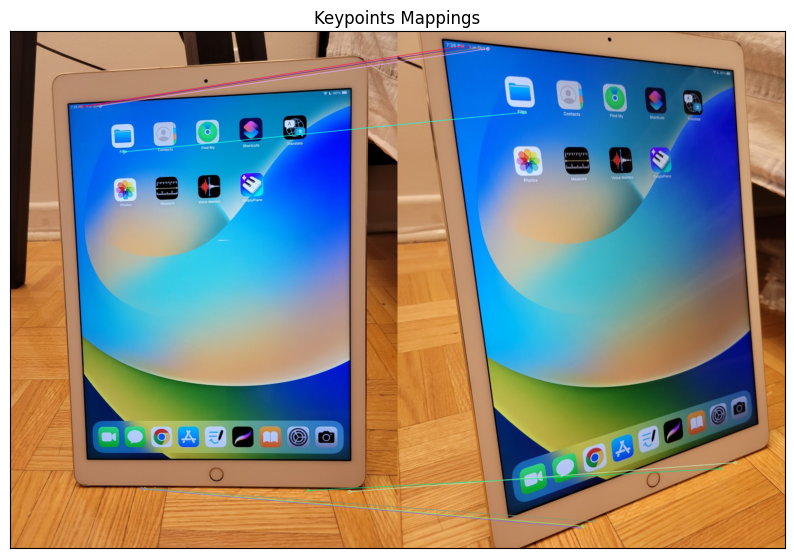

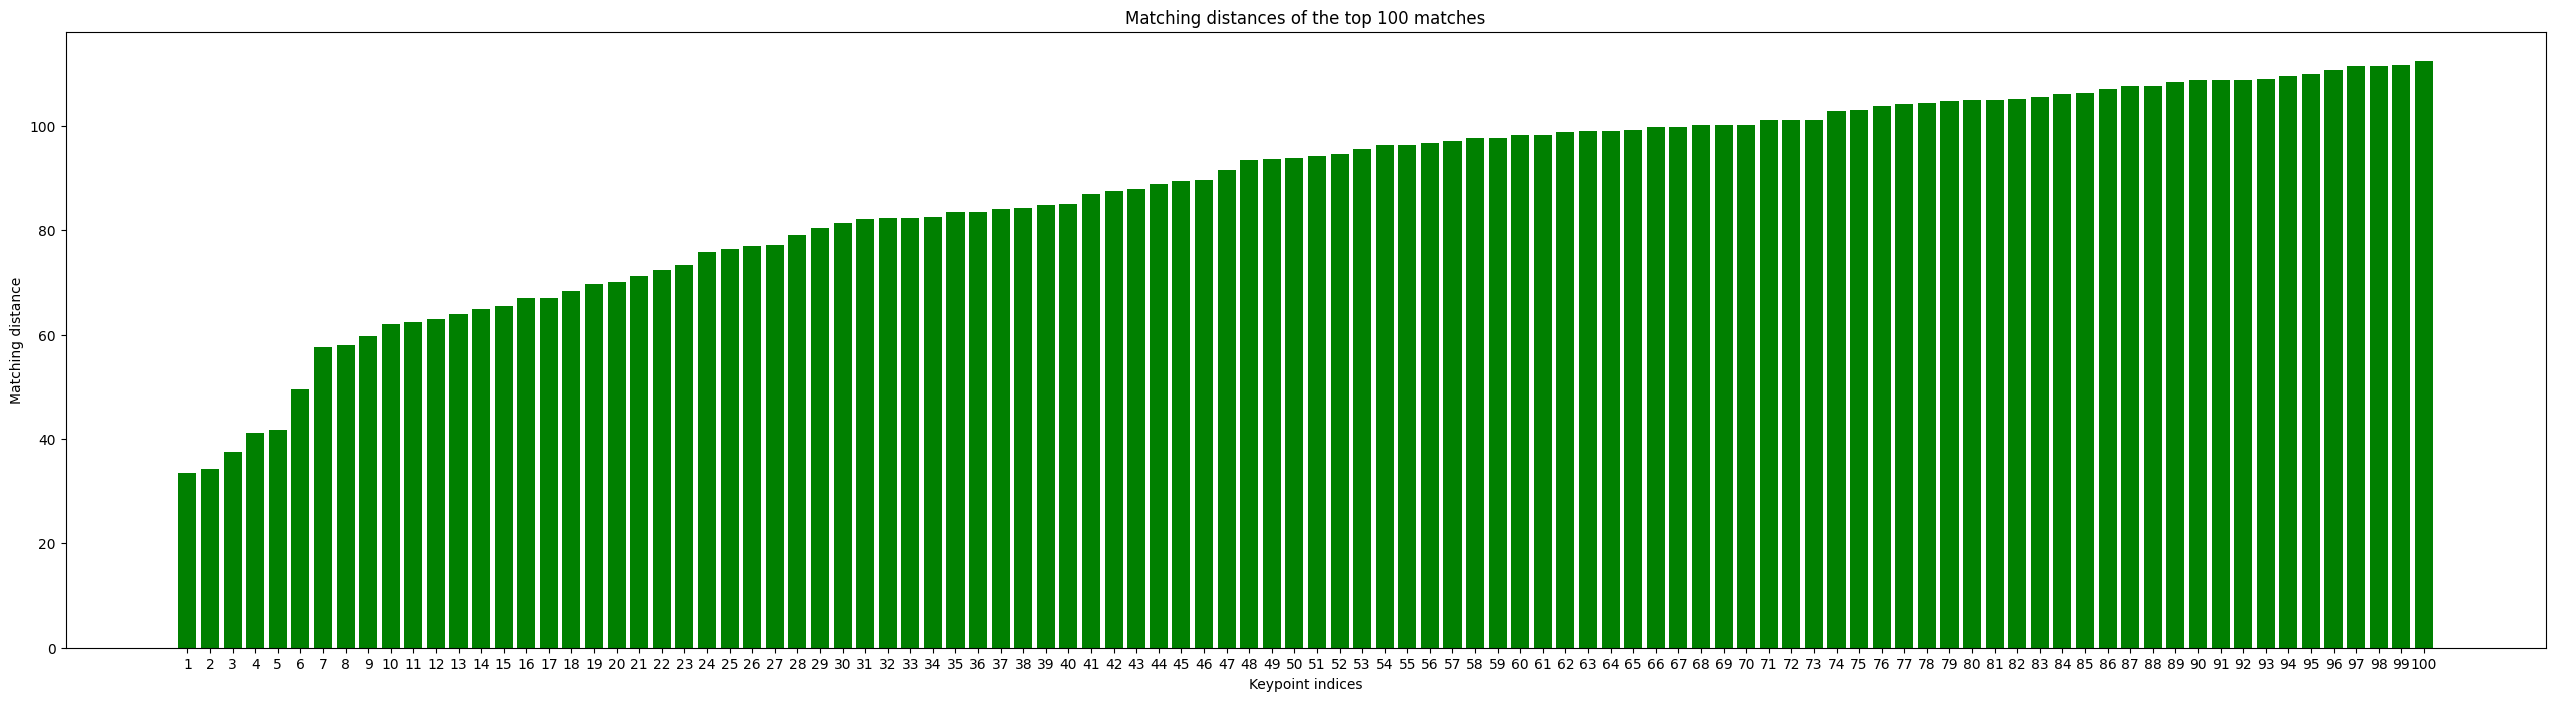

In [ ]:
image_1 = cv2.cvtColor(cv2.imread(path + '1.jpg'), cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(cv2.imread(path + '2.jpg'), cv2.COLOR_BGR2RGB)

# 1. Compute SIFT keypoints for image_1 and image_2
sift = cv2.SIFT_create()
k1, d1 = sift.detectAndCompute(image_1, None)
k2, d2 = sift.detectAndCompute(image_2, None)

# 2. Match all keypoints between two images using a brute-force method
map = cv2.BFMatcher().match(d1, d2)

# 3. Sort the matching keypoints according to the matching distance
map = sorted(map, key = lambda x: x.distance)
distance = [match.distance for match in map[:100]]

# 4. Display the top ten matched keypoints
pic = cv2.drawMatches(image_1, k1, image_2, k2, map[:10], None, flags = 2)

# 5. Plot the matching distance for the top 100 matched keypoints. Plot the indices of keypoints
#    on the x-axis and the corresponding matching distance on the y-axis
keypoints = range(1, 101)

# Outputs
plt.figure(figsize = (10, 9))
plt.imshow(pic)
plt.title("Keypoints Mappings")
plt.yticks([])
plt.xticks([])
plt.show()

plt.figure(figsize = (32, 8))
plt.ylabel('Matching distance')
plt.xlabel('Keypoint indices')
plt.bar(keypoints, distance, alpha = 1, color = 'green')
plt.title("Matching distances of the top 100 matches")
plt.xticks(keypoints)
plt.show()

\
###2.3 Invariance Under Scale (README-4)


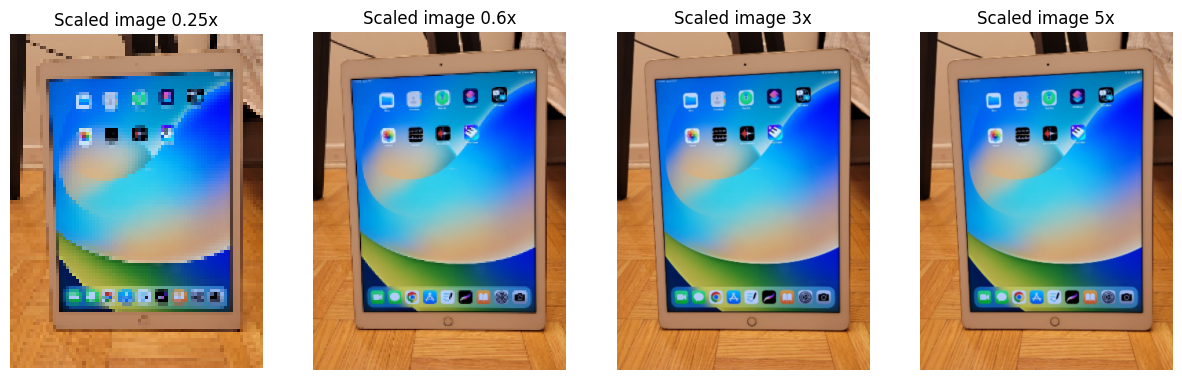

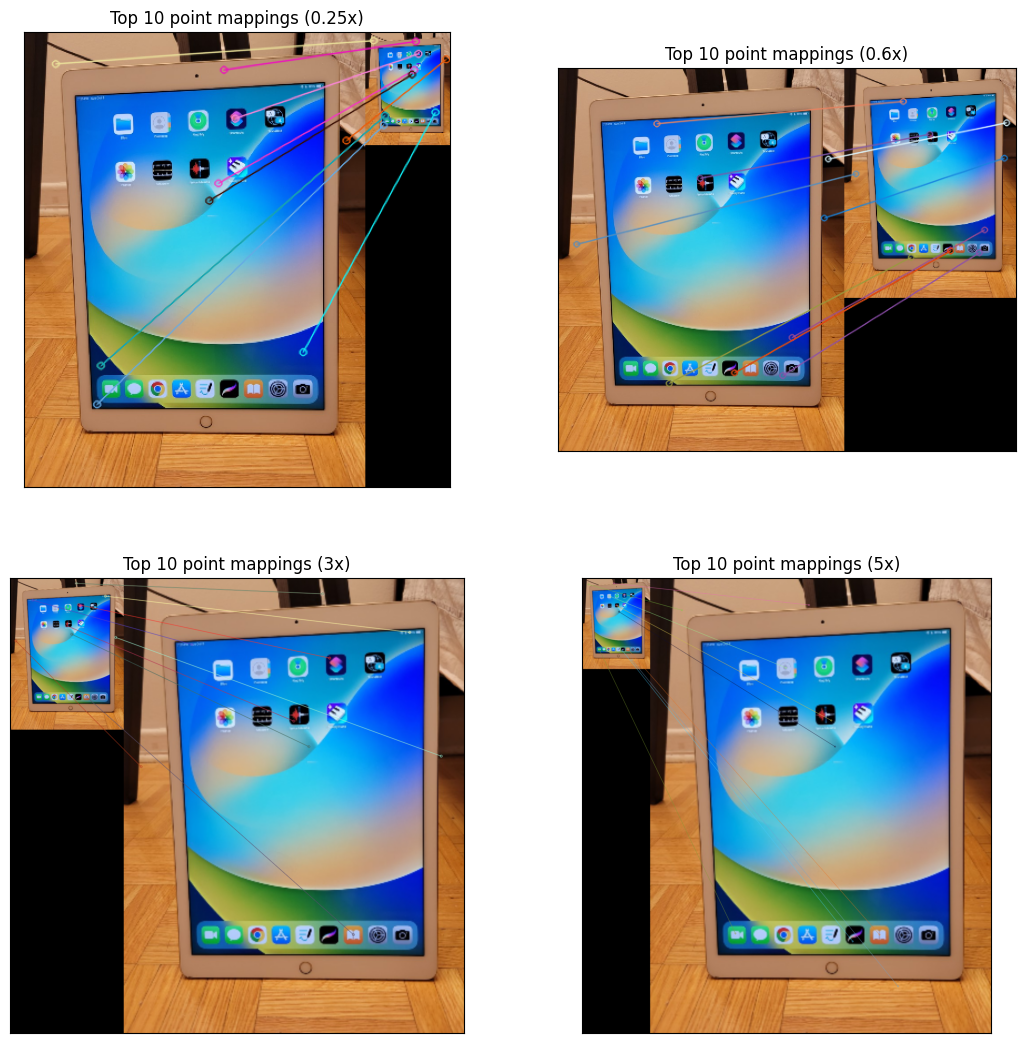

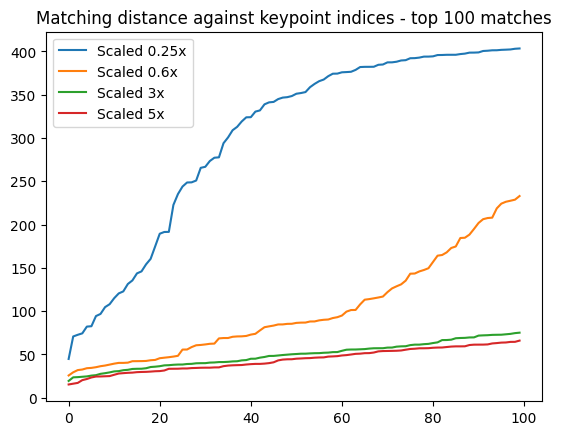

In [ ]:
sf_space = [0.25, 0.6, 3, 5]
image_1 = cv2.resize(cv2.cvtColor(cv2.imread(path + '1.jpg'), cv2.COLOR_BGR2RGB), None, fx = 0.4, fy = 0.4)
sift = cv2.xfeatures2d.SIFT_create()
k1, d1 = sift.detectAndCompute(image_1, None)
points, scaled, distance = [], [], []

# 2. Scale image_1 using scaling factors of (0.25, 0.6, 3, 5). This should result in a total of 4
#    different transformed images. Display scaled images.
fig, axes = plt.subplots(1, len(sf_space), figsize = (15, 5))
for i, sf in enumerate(sf_space):
    image = cv2.resize(image_1, None, fx = sf, fy = sf)
    scaled.append(image)
    axes[i].imshow(image)
    axes[i].set_title(f"Scaled image {sf}x")
    axes[i].axis('off')
plt.show()

# 6. Display the top ten matched keypoints for each pair of the image_1 and a transformed image.
fig, axes = plt.subplots(2, 2, figsize = (13, 13))
for i, image in enumerate(scaled):
    k2, d2 = sift.detectAndCompute(image, None)
    map = sorted(cv2.BFMatcher().match(d1, d2), key = lambda a : a.distance)
    ax = axes[i // 2, i % 2]
    ax.imshow(cv2.drawMatches(image_1, k1, image, k2, map[:10], None, flags = 2))
    ax.set_title(f"Top 10 point mappings ({sf_space[i]}x)")
    ax.set_yticks([])
    ax.set_xticks([])
    distance = [match.distance for match in map[:100]]
    points.append(distance)
plt.show()

# 7. Plot the matching distance for the top 100 matched keypoints. Plot the indices of keypoints
#    on the x-axis and the corresponding matching distance on the y-axis.
tmp = [[] for _ in range(4)]
for index, scale in enumerate(sf_space):
    for i in range(100):
        tmp[index].append(points[index][i])
for index, scale in enumerate(sf_space):
    plt.plot(tmp[index], label = f"Scaled {scale}x")
plt.title("Matching distance against keypoint indices - top 100 matches")
plt.legend()
plt.show()

**2.3-8** Increasing the scale factor results in a decrease in matching distance, leading to a higher number of high-precision matches. Scaling up makes more features noticeable, consequently reducing the matching distance.

\
###2.4 Invariance Under Rotation

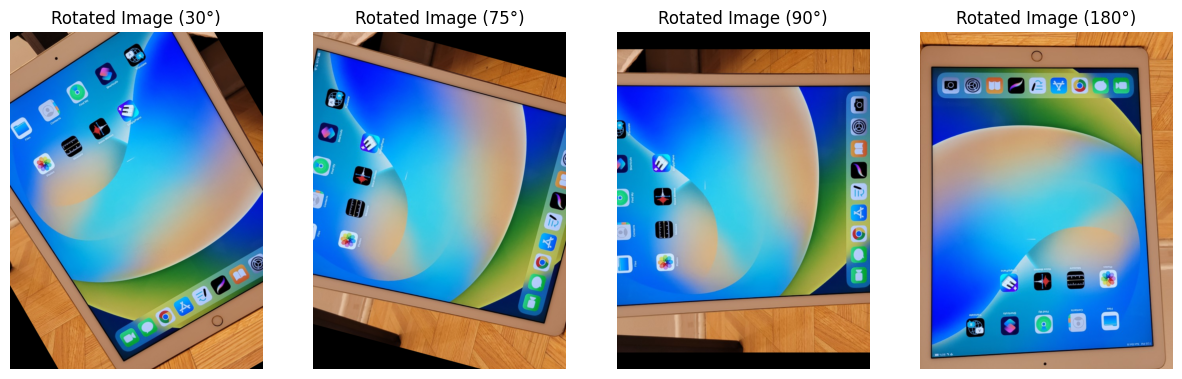

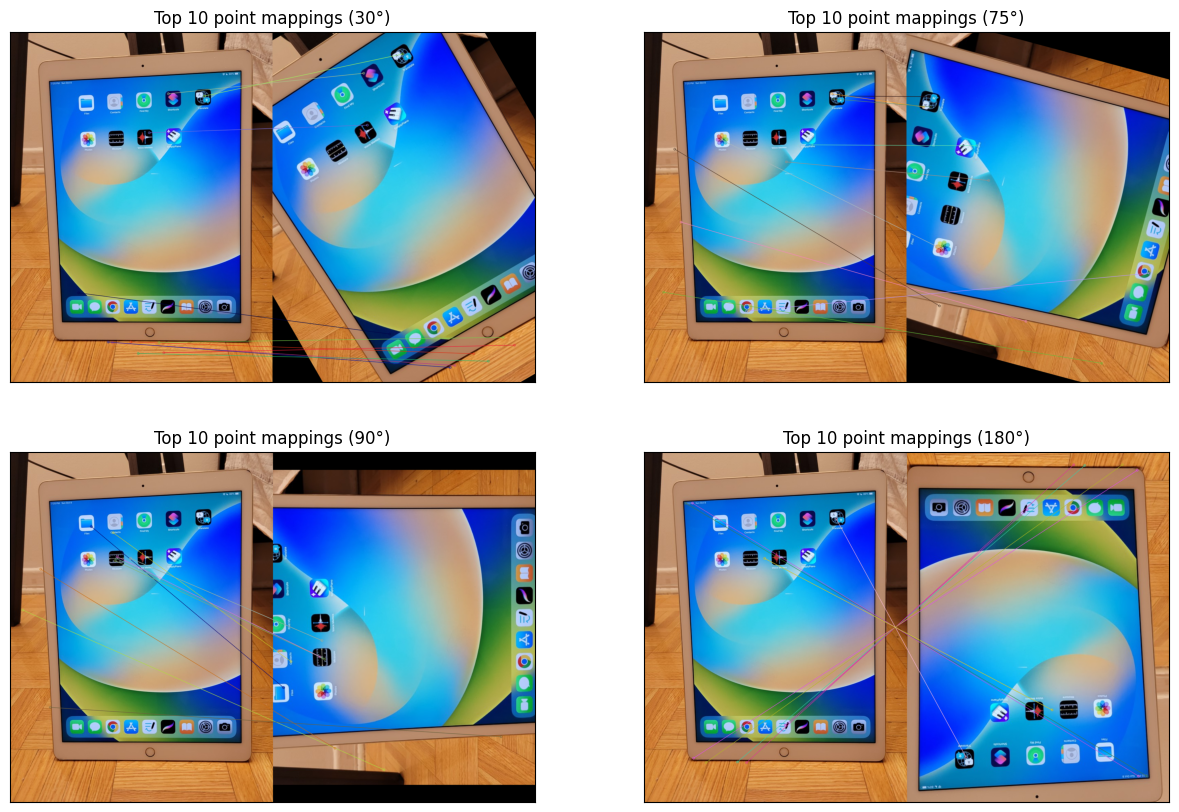

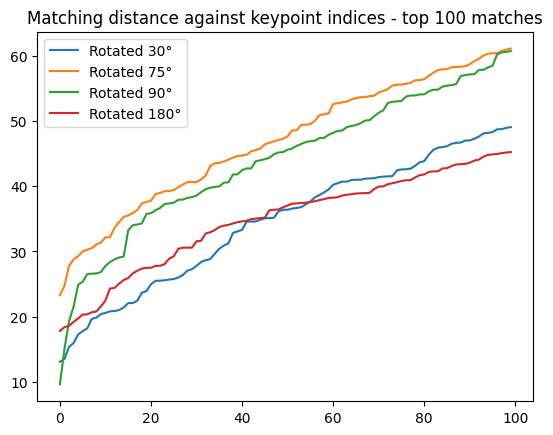

In [ ]:
image_1 = cv2.cvtColor(cv2.imread(path + '1.jpg'), cv2.COLOR_BGR2RGB)
h, w = image_1.shape[:2]
k1, d1 = sift.detectAndCompute(image_1, None)
angle_space = [30, 75, 90, 180]
points, rotated = [], []

# 1. Rotate image_1 at the angle of (30, 75, 90, 180). Display rotated images.
fig, axes = plt.subplots(1, len(angle_space), figsize = (15, 5))
for i, angle in enumerate(angle_space):
    img = cv2.warpAffine(image_1, cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.2), (w, h))
    rotated.append(img)
    axes[i].imshow(img)
    axes[i].set_title(f'Rotated Image ({angle}°)')
    axes[i].axis('off')
plt.show()

# 5. Display the top ten matched keypoints for each pair of image_1 and a transformed image.
fig, axes = plt.subplots(2, len(rotated) // 2, figsize = (15, 10))
for i, img in enumerate(rotated):
    k2, d2 = sift.detectAndCompute(img, None)
    map = sorted(cv2.BFMatcher().match(d1, d2), key = lambda a : a.distance)
    ax = axes[i // 2, i % 2]
    ax.imshow(cv2.drawMatches(image_1, k1, img, k2, map[:10], None, flags = 2))
    ax.set_title(f"Top 10 point mappings ({angle_space[i]}°)")
    ax.set_xticks([])
    ax.set_yticks([])
    points.append([match.distance for match in map[:100]])  # distance matched
plt.show()

# 6. Plot the matching distance for the top 100 matched keypoints. Plot the indices of the key
#    points on the x-axis and the corresponding matching distance on the y-axis.
tmp = [points[i][:100] for i in range(4)]
for i, data in enumerate(tmp):
    plt.plot(data, label = f"Rotated {angle_space[i]}°")
plt.title("Matching distance against keypoint indices - top 100 matches")
plt.legend()
plt.show()

**2.4-7**. As angles increase, matching distance remains fairly consistent. However, from 30° to 180° degrees, there is a slight decrease from 30° to 25° in matching distance. This was due to the image being only inverted, resulting in similar features to the unrotated image. The low overall matching distance is due to the images being the same size.

\
##***3 Image Stitching***

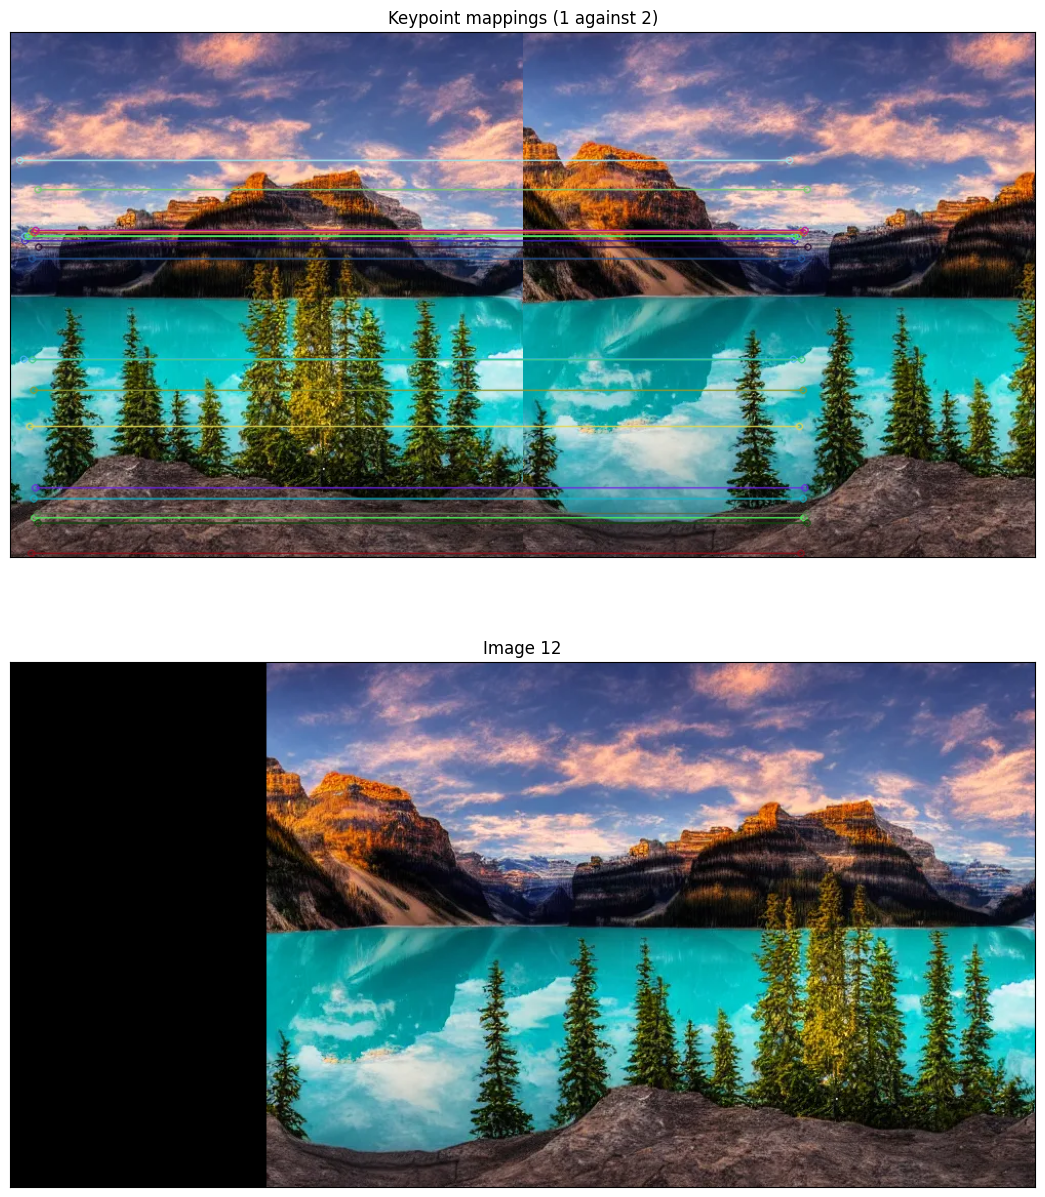

In [ ]:
# (a)-(d)
sift = cv2.xfeatures2d.SIFT_create()
pic1 = cv2.cvtColor(cv2.imread(path + 'part1.png'), cv2.COLOR_BGR2RGB)
pic2 = cv2.cvtColor(cv2.imread(path + 'part2.png'), cv2.COLOR_BGR2RGB)
k1, d1 = sift.detectAndCompute(pic1, None)
k2, d2 = sift.detectAndCompute(pic2, None)
points = []

map = sorted(cv2.BFMatcher().match(d2, d1), key = lambda a : a.distance)
raw = cv2.drawMatches(pic2, k2, pic1, k1, map[:20], None, flags = 2)
for i, j in enumerate(map):
    if j.distance < 1000:
        points.append((j.trainIdx, j.queryIdx))
t2 = np.float32([k2[i].pt for (__, i) in points])
for i in range(len(t2)):
   t2[i][0] += pic1.shape[1]
Graph, __ = cv2.findHomography(np.float32([k1[i].pt for (i, __) in points]), t2, cv2.RANSAC, 4)
lm_combined = cv2.warpPerspective(pic1, Graph, (pic1.shape[1] + pic2.shape[1], pic2.shape[0]), flags = cv2.INTER_LINEAR)
lm_combined[:,lm_combined.shape[1] - pic2.shape[1]:lm_combined.shape[1],:] = pic2

# (b) Find matching keypoints in images 1 and display the 20 best pairs
plt.figure(figsize = (15, 15))
plt.subplot(211)
plt.imshow(raw)
plt.title("Keypoint mappings (1 against 2)")
plt.yticks([])
plt.xticks([])

# (d) Stitch the transformed image 1 and the original image 2 together using linear image
#     blending. Let us call this image 12. Display this image
plt.subplot(212)
plt.imshow(lm_combined)
plt.title("Image 12")
plt.yticks([])
plt.xticks([])
plt.show()

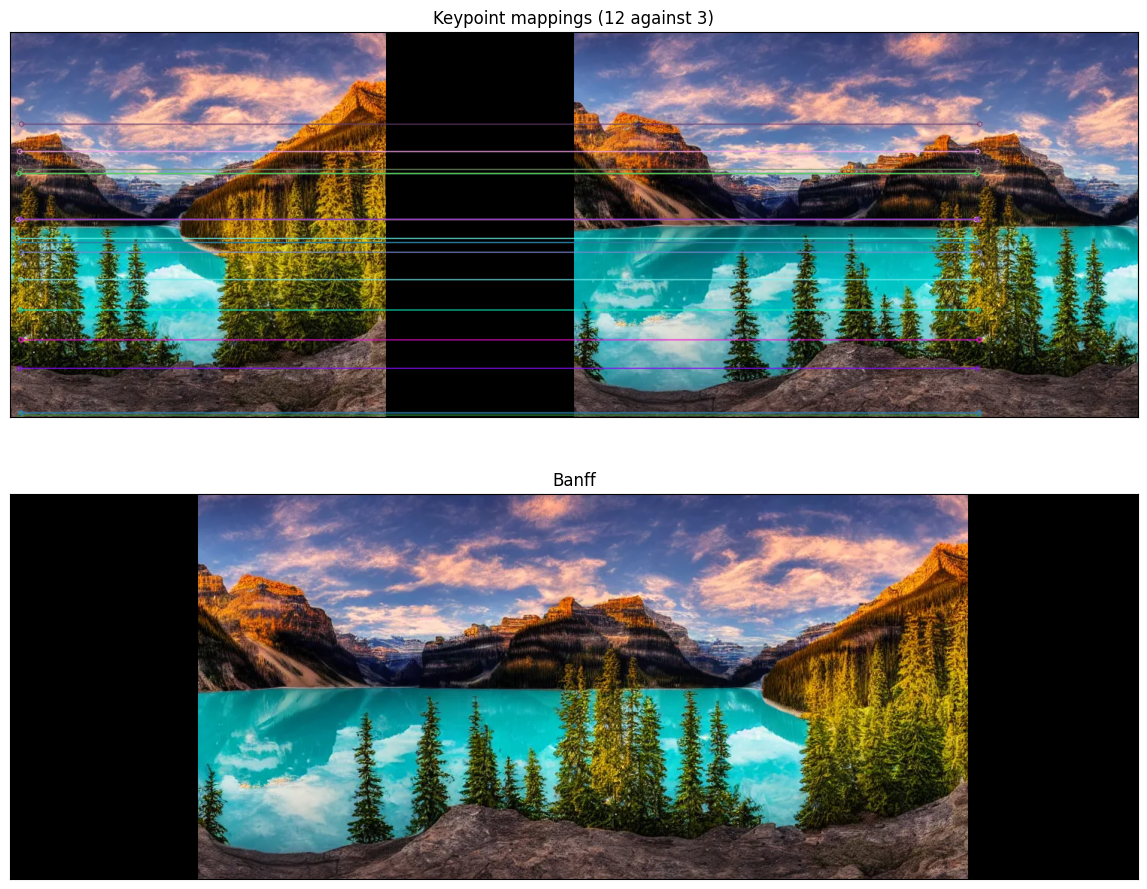

In [ ]:
# (e) to (h), similar to the implementaion of (a) to (d)
sift = cv2.xfeatures2d.SIFT_create()
pic12 = lm_combined.copy()
pic3 = cv2.cvtColor(cv2.imread(path + 'part3.png'), cv2.COLOR_BGR2RGB)  # right view
k3, d3 = sift.detectAndCompute(pic3, None)
k12, d12 = sift.detectAndCompute(pic12, None)
lepoint = []

map = sorted(cv2.BFMatcher().match(d3, d12), key = lambda a : a.distance)
raw = cv2.drawMatches(pic3, k3, pic12, k12, map[:20], None, flags = 2)
for i, j in enumerate(map):
    if j.distance < 1000:
        lepoint.append((j.trainIdx, j.queryIdx))
Graph, __ = cv2.findHomography(np.float32([k3[i].pt for (__, i) in lepoint]), np.float32([k12[i].pt for (i, __) in lepoint]), cv2.RANSAC, 4)
combined = cv2.warpPerspective(pic3, Graph, (pic12.shape[1] + pic3.shape[1], pic3.shape[0]), flags = cv2.INTER_LINEAR)
combined[:,:pic12.shape[1],:] = pic12

# (f) Find the matching keypoints in 12 and 3 images and display the 20 best pairs
plt.figure(figsize = (15, 11))
plt.subplot(211)
plt.imshow(raw)
plt.title("Keypoint mappings (12 against 3)")
plt.yticks([])
plt.xticks([])
# (h) Stitch the transformed image 3 and image 12 together using linear image blending.
#     Display the resulting image
plt.subplot(212)
plt.imshow(combined)
plt.title("Banff")
plt.yticks([])
plt.xticks([])
plt.show()

**3(i)** One may prefer pyramid blending over linear blending when they needs a seamless transition between stitched images, has images with varying levels of detail, or wants to reduce ghosting artifacts caused by moving objects or changing illumination. Pyramid blending is a multi-resolution approach that can handle these situations effectively while maintaining natural-looking results.